In [3]:
import os
import re
import sys
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from nltk.stem import WordNetLemmatizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

%matplotlib inline

Baseline: равновероятный выбор между всеми главными героями. +

Примерный план действий: 

нормализовать (свой выбор процедур объяснить (например, нужно ли включать в стоп-лист обсценную лексику?); +

векторизовать (например, CountVectorizer), +

отрезать проверочную выборку (эту часть не трогаем до последней проверки). +

На оставшейся, большей, части данных: 

1) немного поанализировать данные, чтобы понять, какие признаки могут помочь при обучении — 

- например, построить частотные списки 

- и сравнить их (достаточно ли матрицы терм-документ с ненормализованными вхождениями слов?);  

2) обучить модели 
- (лес, +

- наивный байес, +

- логит) +-

и подобрать их оптимальные параметры. +

Интерпретировать параметры (атрибуты) лучших моделей. +

Протестировать их на проверочной выборке, +

выбрать лучшую модель, 

проиллюстрировать результат (например, нарисовать decision surface). 

Сравнить результат с нехитрым Baseline классификатором.

In [2]:
# загружаем данные
data = []
root = './blogs'
for fil in os.listdir(root):
    try:
        meta = fil.split('.')[1:3]
        content = open(os.path.join(root, fil), "r", encoding='utf-8', errors='ignore').read()
        data.append(meta+[content])
    except:
        print(os.path.join(root, fil))

In [3]:
data = pd.DataFrame(data, columns=['gender', 'age', 'posts'])
data.head()

,gender,age,posts
0,female,37,"<Blog>\n\n<date>31,May,2004</date>\n<post>\n\n..."
1,female,17,"<Blog>\n\n<date>23,November,2002</date>\n<post..."
2,male,23,"<Blog>\n\n<date>19,June,2004</date>\n<post>\n\..."
3,female,25,"<Blog>\n\n\n\n<date>31,May,2004</date>\n<post>..."
4,male,25,"<Blog>\n\n<date>05,July,2003</date>\n<post>\n\..."


In [5]:
# нормализовать
# я читаю "обратить внимание на тэги" как "не забыть удалить теги"
# не убираю urlLink потому что количество ссылок может играть роль
data['normalized'] = data['posts'].map(lambda x: re.sub('</?[(?:Blog)|(?:post)]+>|<date>[^<]+</date>', '', x))
data['normalized'] = data['normalized'].map(lambda x: re.sub('\s{2,}', ' ', x).strip())

In [50]:
data.head()

,gender,age,posts,normalized
0,female,37,"<Blog>\n\n<date>31,May,2004</date>\n<post>\n\n...","Well, everyone got up and going this morning. ..."
1,female,17,"<Blog>\n\n<date>23,November,2002</date>\n<post...","Yeah, sorry for not writing for a whole there,..."
2,male,23,"<Blog>\n\n<date>19,June,2004</date>\n<post>\n\...","cupid,please hear my cry, cupid, please let yo..."
3,female,25,"<Blog>\n\n\n\n<date>31,May,2004</date>\n<post>...",and did i mention that i no longer have to dea...
4,male,25,"<Blog>\n\n<date>05,July,2003</date>\n<post>\n\...",B-Logs: The Business Blogs Paradox urlLink Hin...


In [9]:
# сохранить и выкачать, чтобы не тратить на это время после перезапуска ядра
data.to_pickle('blogdata.pickle')

In [4]:
data = pd.read_pickle('blogdata.pickle')

In [5]:
# режем
X_train, X_test, y_train, y_test = train_test_split(data, data['gender'])

например, построить частотные списки и сравнить их (достаточно ли матрицы терм-документ с ненормализованными вхождениями слов?)

In [6]:
# всякие аналитики
male = X_train.loc[X_train['gender']=='male']['normalized']
female = X_train.loc[X_train['gender']=='female']['normalized']

In [139]:
# import time

t1 = time.clock()
counter_male = list(map(lambda man: list(map(lambda x: x.strip('.,?!"() @:;'), man.lower().split())), male))
t2 = time.clock()
print('men finished')
print('in {}'.format(t2-t1))

t1 = time.clock()
counter_female = list(map(lambda woman: list(map(lambda x: x.strip('.,?!"() @:;'), woman.lower().split())), female))
t2 = time.clock()
print('women finished')
print('in {}'.format(t2-t1))



# male_count = {}
# t1 = time.clock()
# for man in counter_male:
# #     man = list(map(lambda x: x.strip('.,?!"@:;'), man.lower().split()))
#     male_count = dict(Counter(male_count)+Counter(man))
# t2 = time.clock()
# print('men finished')
# print('in {}'.format(t2-t1))

# female_count = {}
# t1 = time.clock()
# for woman in counter_female:
# #     woman = list(map(lambda x: x.strip('.,?!"@:;'), woman.lower().split()))
#     female_count = dict(Counter(female_count)+Counter(woman))
# t2 = time.clock()
# print('women finished')
# print('in {}'.format(t2-t1))

# freqlists = pd.DataFrame({'male': sorted(male_count, key=male_count.get)[:50], 'female': sorted(female_count, key=female_count.get)[:50]})
# freqlists.head()

men finished
in 44.078654000000824
women finished
in 37.251775000000634


In [138]:
freqlists = pd.DataFrame({'male': sorted(male_count, key=male_count.get)[:50], 'female': sorted(female_count, key=female_count.get)[:50]})
freqlists.head()

,female,male
0,材,everything.)
1,堵,flipped...and
2,⵽,re-occur
3,糯,converseration
4,얼,on.&nbsp;&nbsp;&nbsp;&nbsp;&nbsp


In [7]:
# векторизовать
# никаких дополнительных стоп-слов не добавляю, потому что это обычный текст на английском
cv = CountVectorizer(preprocessor=WordNetLemmatizer().lemmatize, stop_words='english', min_df=2, max_df=0.95)
cv = cv.fit_transform(data['normalized'])
tfidf_transformer = TfidfTransformer()
tfidf = tfidf_transformer.fit_transform(cv)

In [8]:
# ещё раз режем
X_train, X_test, y_train, y_test = train_test_split(tfidf, data['gender'])

In [116]:
# baseline - рандомно приписываем класс
def dummy_classifier(X):
    res = [random.choice(['male', 'female']) for i in range(X.shape[0])]
    return res
prediction = dummy_classifier(X_test)
print('Results:')
print(classification_report(y_test, prediction))
print('Confusion matrix:')
print(confusion_matrix(y_test, prediction))

Results:
             precision    recall  f1-score   support

     female       0.51      0.50      0.51      2432
       male       0.50      0.51      0.51      2398

avg / total       0.51      0.51      0.51      4830

Confusion matrix:
[[1220 1212]
 [1172 1226]]


Очевидным образом, если у нас два уравновешенных класса, dummy-clasifier справляется в половине случаев.

Random Forest. Выбираю всё те же характеристики для варьирования: n_estimators, потому что это эндемичная штука леса, которая очень влияет на результат, и max_depth 

In [9]:
def how_to_train_your_model(model, model_name, parameters, scoring=None):
    print('Tuning {} with GridSearch'.format(model_name))
    print()
    print('Parameters:\n\t{}'.format('\n\t'.join(list(parameters.keys()))))
    print()
    sys.stdout.write('Fitting models...')
    gs = GridSearchCV(model, parameters)
    gs = gs.fit(X_train, y_train)
    sys.stdout.write('Fitted')

    # здесь про параметры
    print()
    print("Best parameters set:")
    best_parameters = gs.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t{}: {}".format(param_name, best_parameters[param_name]))
    print()
    print('Predicting test values...')
    prediction = gs.predict(X_test)
    print('Results:')
    print(classification_report(y_test, prediction))
    print('Confusion matrix:')
    print(confusion_matrix(y_test, prediction))
    print()
    print('Parameters and results for training set:')
    means = list(map(lambda x: round(x, 3), gs.cv_results_['mean_test_score']))
    params_order = sorted(parameters.keys())
    if len(parameters)==2:
        data = []
        for mean, params in zip(means, gs.cv_results_['params']):
            data.append([mean, params[params_order[0]], params[params_order[1]]])
        data = pd.DataFrame(data, columns=['mean']+params_order).fillna("None")
        data = data.pivot(params_order[0], params_order[1], 'mean')
        sns.heatmap(data, annot=True, cbar=False);
    elif len(parameters)==1:
        sns.pointplot(parameters[params_order[0]], means);
    return gs

Tuning RandomForest with GridSearch

Parameters are:
	n_estimators
	max_depth

Fitting models...
Fitted

Best parameters set:
	max_depth: 7
	n_estimators: 100

Predicting test values...
Results are:
             precision    recall  f1-score   support

     female       0.68      0.78      0.73      2386
       male       0.75      0.64      0.69      2444

avg / total       0.72      0.71      0.71      4830

Confusion matrix:
[[1872  514]
 [ 881 1563]]
Parameters and results for training set:


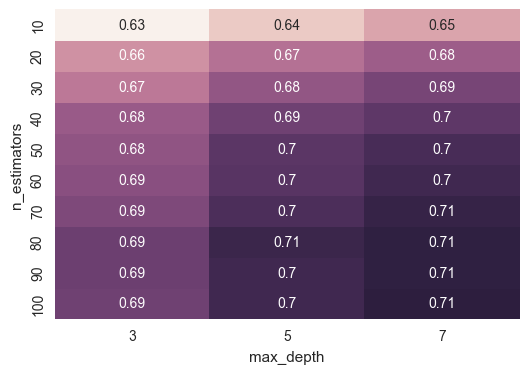

In [48]:
# лес
parameters = {'n_estimators': list(range(10, 101, 10)), 'max_depth': [3, 5, 7]} # list(range(1, 10, 2))
forest = RandomForestClassifier(random_state=6, n_jobs=-1, error_score=np.NaN)
how_to_train_your_model(forest, 'RandomForest', parameters)

Окей, лучшие параметры леса - глубина 7 при 100 деревьях. Можно попробовать потренировать более точно:

Tuning RandomForest with GridSearch

Parameters:
	n_estimators
	max_depth

Fitting models...Fitted
Best parameters set:
	max_depth: 8
	n_estimators: 110

Predicting test values...
Results:
             precision    recall  f1-score   support

     female       0.73      0.77      0.75      2424
       male       0.75      0.71      0.73      2406

avg / total       0.74      0.74      0.74      4830

Confusion matrix:
[[1864  560]
 [ 704 1702]]

Parameters and results for training set:


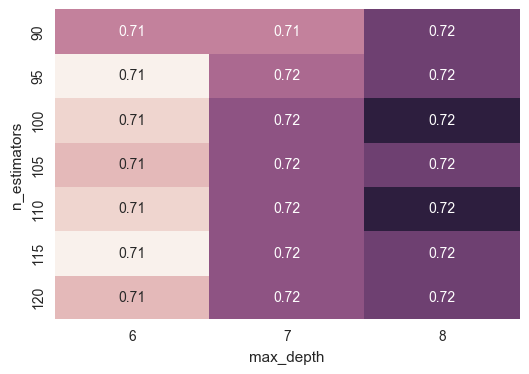

In [68]:
forest = RandomForestClassifier(random_state=6, n_jobs=-1, error_score=np.NaN)
parameters = {'n_estimators': list(range(90, 121, 5)), 'max_depth': [6, 7, 8]}
how_to_train_your_model(forest, 'RandomForest', parameters)

Кажется, здесь начинается какой-то рандом (я не могу увидеть паттерн). Да и разница между значениями не такая уж и большая. Тем не менее, на результат повлияло довольно значительно: +3% к f-мере на тестовой выборке. По сравнению с предыдущей моделью эта (max_depth=8, n_estimators=110) лучше размечает мужчин (особенно повезло полноте, она выросла на все 7%), в то время как разметка женщин почти не улучшилась (точнее, в соответствии с ростом полноты для мужчин выросла точность для женщин - на 5%).

Однако всё это похоже на переобучение (нужно больше деревьев, нужно больше слоёв, когда оба эти параметра как раз позволяют контролировать переобучение), так что сделаю вид, что остановилась на грани, и дальше идти (ещё увеличивать глубину, например) не буду.

In [87]:
# мы знаем, что confusion_matrix упорядочивает классы по алфавиту, строки - how it really is, 
# столбцы - как разметила модель, но вот на всякий случай доказательство
sum([1 for i in y_test if i=='female'])

2424

Настраиваем Naive Bayes. Попробую варьировать параметр alpha, который (как я поняла) призван предупредить не попавшие в training set фичи и уберечь от нулевой вероятности; варьирую от 0.1 (чтобы не делить на ноль) до 1.0 (~от Лидстоуна до Лапласа). Кроме того, можно уже попробовать повыбирать метрики, которые использует GridSearch

Tuning for precision
Tuning NaiveBayes with GridSearch

Parameters:
	alpha

Fitting models...Fitted
Best parameters set:
	alpha: 0.1

Predicting test values...
Results:
             precision    recall  f1-score   support

     female       0.70      0.83      0.76      2432
       male       0.79      0.65      0.71      2398

avg / total       0.75      0.74      0.74      4830

Confusion matrix:
[[2022  410]
 [ 851 1547]]

Parameters and results for training set:

Tuning for recall
Tuning NaiveBayes with GridSearch

Parameters:
	alpha

Fitting models...Fitted
Best parameters set:
	alpha: 0.1

Predicting test values...
Results:
             precision    recall  f1-score   support

     female       0.70      0.83      0.76      2432
       male       0.79      0.65      0.71      2398

avg / total       0.75      0.74      0.74      4830

Confusion matrix:
[[2022  410]
 [ 851 1547]]

Parameters and results for training set:

Tuning for accuracy
Tuning NaiveBayes with GridSearch

Para

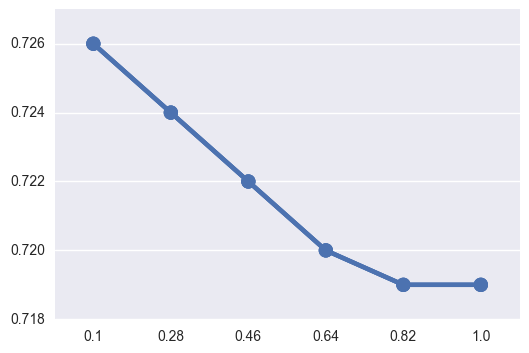

In [120]:
parameters = {'alpha': np.linspace(0.1, 1.0, 6)}
scorings = ['precision', 'recall', 'accuracy']
bayes = MultinomialNB()

bayes_scorings = []
for scoring in scorings:
    print('Tuning for {}'.format(scoring))
    gs = how_to_train_your_model(bayes, 'NaiveBayes', parameters, scoring=scoring)
    bayes_scorings.append(gs)
    print()

Совершенно восхитительным образом чем ближе альфа к нулю, тем лучше. Я понимаю это как то, что данные исчерпывающие и никаких дополнительных фич ожидать больше не нужно (но я скорее всего неправа). Плюс scoring method не играет никакой роли (=the hyperparameter plateau is too flat)

Итак, собственно, логитрегрессия. Класс бинарный, следовательно, настраивать solver и выбирать multinomial multi_class не нужно, и дефолтный liblinear solver должен by design справиться лучше всего. С другой стороны датасет довольно большой, так что можно попробовать использовать приспособленный для этого sag. Ну и опять же параметр C, который чем меньше, тем регулярней, а чем больше, тем потенциально выше вероятность оверфита.

Tuning binary LogisticRegression with GridSearch

Parameters:
	C

Fitting models...done

Best parameters set:
	C: 2.5

Predicting test values...done

Results:
             precision    recall  f1-score   support

     female       0.82      0.82      0.82      2386
       male       0.82      0.82      0.82      2444

avg / total       0.82      0.82      0.82      4830

Confusion matrix:
[[1949  437]
 [ 430 2014]]

Parameters and results:


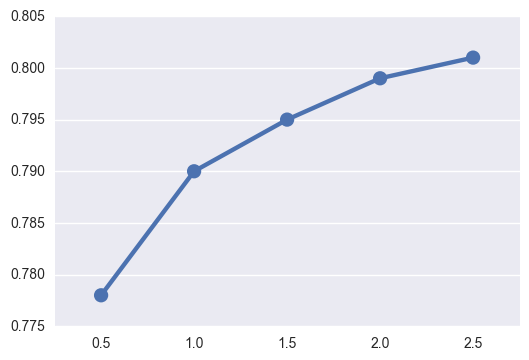

In [73]:
# логрег
lgrg = LogisticRegression(random_state=4, n_jobs=-1)
parameters_lgrg = {'C': [0.5, 1.0, 1.5, 2.0, 2.5]}
lgrg_cv = how_to_train_your_model(lgrg, 'binary LogisticRegression', parameters_lgrg)

In [ ]:
lgrg = LogisticRegression(random_state=4, n_jobs=-1)
parameters = {'C': np.linspace(0.5, 3.5, 7), 'solver': ['liblinear', 'sag']}
gs_lgrg = how_to_train_your_model(lgrg, 'binary LogisticRegression', parameters)

Tuning binary LogisticRegression with GridSearch

Parameters:
	solver
	C

Fitting models...

Выходит, что действительно для бинарного класса можно обойтись заводскими настройками solver, потому что в таком случае solver всё равно ничего не решает, а большие значения C показывают, что модель тяготеет к меньшей регулярности и большей сложности. Как и лес с глубиной дерева 8 и большим количеством деревьев - это всё (как мне кажется) вполне объяснимо просто самими данными: больше 350000 фич, sparce matrices, естественный язык и понятно, что вероятность успеха условного OneR крайне мала

Ну а теперь собственно параметры логитрегрессии

In [ ]:
clf = gs_lgrg.best_estimator_
clf.coef_

Это было глупо, потому что здесь все 351379 фич

In [ ]:
clf.intercept_

In [ ]:
# от коэффициентов через logodds к вероятности
# logodds = [clf.intercept_ + clf.coef_[i] * value[i] for i in range(len(clf.coef_))]
logodds = [clf.intercept_ + clf.coef_[i] for i in range(len(clf.coef_))]
odds = np.exp(logodds)
prob = odds/(1 + odds)

In [ ]:
od = np.exp(clf.intercept_)
pr = od/(1+od)
pr

Если я хоть что-то понимаю, теперь в prob под индексом i лежит вероятность того, что при условии того, что в тексте блога содержится терм i, мы можем утверждать, что автор - мужчина (нет, сейчас нет, но если подставить в value в закмменченной строчке какую-нибудь строку из данных, то будет, кажется). Это полезно, если мы хотим составить список самых как бы мужских и женских слов, наверно (хотя это можно сделать гораздо проще). И, соответственно, если произведение всех вот этих вероятностей больше intersept, то это мужчина, если меньше, то женщина

In [ ]:
probs = [prob[0][10*i] for i in range(len(sorted(prob[0]))/100)]
sns.pointplot(np.linspace(0, len(probs), len(probs)), probs)